In [1]:
!pip install geopandas
import geopandas as gpd
import numpy as np

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load shapefiles

In [3]:
# Read shapefiles
pred_boxes = gpd.read_file('/content/drive/MyDrive/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_galbyveien_20230504_sun/10m_galbyveien_20230504_sun_predictions_all_annot_medium_640_conf_0_2.shp')

ref_boxes = gpd.read_file('/content/drive/MyDrive/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/test_annotations2_sun.geojson')
aois = gpd.read_file('/content/drive/MyDrive/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/aois.geojson')  # Shapefile containing multiple AOIs


# plots

<ipython-input-4-eca34b1be040>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


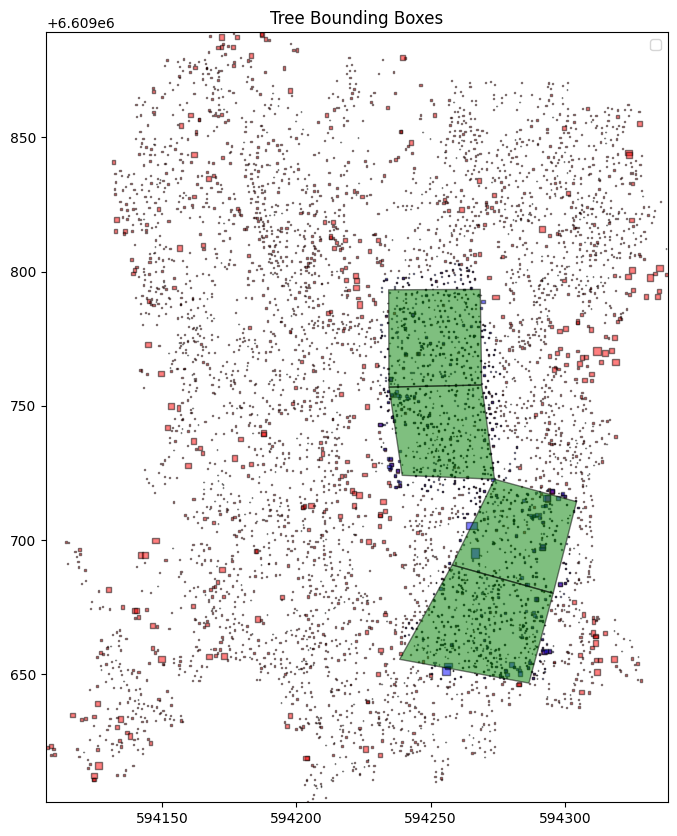

In [4]:
import matplotlib.pyplot as plt

# Plotting the shapefiles
fig, ax = plt.subplots(figsize=(10, 10))

# Plot predicted boxes
pred_boxes.plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label='Predicted Boxes')

# Plot reference boxes
ref_boxes.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='Reference Boxes')

# Plot AOI
aois.plot(ax=ax, color='green', edgecolor='black', alpha=0.5, label='AOI')

# Zoom to the extent of predicted boxes
ax.set_xlim(pred_boxes.total_bounds[0], pred_boxes.total_bounds[2])
ax.set_ylim(pred_boxes.total_bounds[1], pred_boxes.total_bounds[3])

# Set plot title and legend
plt.title('Tree Bounding Boxes')
plt.legend()

# Display the plot
plt.show()

# Compute residuals

In [5]:
# Initialize lists to store residuals for each AOI
residuals = []

# Compute residuals for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    residual = num_pred_within_aoi - num_ref_within_aoi
    residuals.append(residual)


In [6]:
residuals

[-153, -115, -41, -135]

# Compute RMSE

In [7]:
# Compute RMSE
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias= np.mean(residuals)
print("the RMSE is: "+ str(rmse))
print("the bias is: "+ str(bias))

the RMSE is: 118.89070611279925
the bias is: -111.0


In [8]:
aois

,id,aoi_name,geometry
0,NaN,NaN,"MULTIPOLYGON (((594269.014 6609757.765, 594234..."
1,NaN,NaN,"MULTIPOLYGON (((594234.465 6609756.975, 594269..."
2,NaN,NaN,"MULTIPOLYGON (((594273.794 6609722.675, 594304..."
3,NaN,NaN,"MULTIPOLYGON (((594258.021 6609690.758, 594295..."


In [9]:



# Print residuals and RMSE
for i, aoi in enumerate(aois.iterrows()):
    aoi_name = aoi[1]['aoi_name']  # Assuming you have a column 'aoi_name' in your AOIs shapefile
    print("Residual for AOI"+ str(aoi_name) + ":" +str(residuals[i]))

print("RMSE:"+  str(rmse))

Residual for AOInan:-153
Residual for AOInan:-115
Residual for AOInan:-41
Residual for AOInan:-135
RMSE:118.89070611279925


# Now we are going to per hectare values

In [10]:
# Initialize lists to store the number of boxes per hectare for each AOI
box_density = []

# Compute the number of boxes per hectare for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    area = aoi_geom.area  # Area in square meters
    area_ha = area / 10000  # Convert area to hectares
    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    pred_density = num_pred_within_aoi / area_ha
    ref_density = num_ref_within_aoi / area_ha

    box_density.append((pred_density, ref_density))

In [11]:
box_density

[(1054.0359321281346, 2294.555144555862),
 (1274.129763766961, 2257.5185076139446),
 (1015.61159862361, 1346.0883886519275),
 (1367.2419865468821, 2206.2313873824687)]

In [12]:

# Print box density for each AOI
for i, aoi in enumerate(aois.iterrows()):
    aoi_name = aoi[1]['aoi_name']  # Assuming you have a column 'aoi_name' in your AOIs shapefile
    pred_density, ref_density = box_density[i]
    print("Box density for AOI"+ str(aoi_name) + ":")
    print("Predicted density (boxes/ha):"+ str(pred_density))
    print("Reference density (boxes/ha):"+ str(ref_density))
    print()


Box density for AOInan:
Predicted density (boxes/ha):1054.0359321281346
Reference density (boxes/ha):2294.555144555862

Box density for AOInan:
Predicted density (boxes/ha):1274.129763766961
Reference density (boxes/ha):2257.5185076139446

Box density for AOInan:
Predicted density (boxes/ha):1015.61159862361
Reference density (boxes/ha):1346.0883886519275

Box density for AOInan:
Predicted density (boxes/ha):1367.2419865468821
Reference density (boxes/ha):2206.2313873824687



In [13]:

# Compute RMSE of box density
pred_densities, ref_densities = zip(*box_density)
residuals = np.array(pred_densities) - np.array(ref_densities)
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias = np.mean(residuals)

rmse_rel= rmse/np.mean(ref_densities)*100
bias_rel= bias/np.mean(ref_densities)*100

print("RMSE of box density (boxes/ha):"+ str(rmse))
print("relative RMSE of box density (%):"+ str(rmse_rel))

print("bias of box density (boxes/ha):"+ str(bias))
print("relative bias of box density (%):"+ str(bias_rel))


RMSE of box density (boxes/ha):910.9143018677902
relative RMSE of box density (%):44.95903659848031
bias of box density (boxes/ha):-848.3435367846539
relative bias of box density (%):-41.870797329869134
